# Part-3: Activations, Gradients and BatchNorm

## 1. Introduction

In this part we dive into the practical challenges of training neural networks and introduces powerful techniques like Batch Normalization to make our models train faster and better.

## 2. Setup and Data Loading

In [1]:
import torch
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

### Reading the Names Dataset

Like previous parts we load the names.txt file into a Python list called words.



In [2]:
words = open('names.txt', 'r').read().splitlines() # list of strings
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

### Building the Vocabulary

We create our character-to-integer `(stoi)` and integer-to-character `(itos)` mappings. This vocabulary is essential for converting our text data into a numerical format for the network. We also define `vocab_size` which we'll need for the dimensions of our output layer.

In [4]:
chars = sorted(list(set(''.join(words))))# unique characters in the dataset
stoi = {s: i+1 for i, s in enumerate(chars)}# char to int mapping
stoi['.'] = 0# we will use '.' as a special character to represent "end of string"
itos = {i: s for s, i in stoi.items()}# int to char mapping
vocab_size = len(itos)# vocab size
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
print(vocab_size)

27


## 2. Dataset Preparation

### Creating the Dataset (Train/Val/Test Split)

In [6]:
block_size = 3#context length: how many characters do we take to predict the next one?


def build_dataset(words):
  X, Y = [], []# X is the input, Y is the target

  for w in words:
    context = [0] * block_size# initialize the context with 'block_size' zeros
    for ch in w + '.':# we add the special character '.' to the end of each word
      ix = stoi[ch]# get the integer representation of the character
      X.append(context)# append the current context to X
      Y.append(ix)# append the target character to Y
      context = context[1:] + [ix]# slide the context window and add the new character

  X = torch.tensor(X)# convert to tensor
  Y = torch.tensor(Y)# convert to tensor
  print(X.shape, Y.shape)# print the shape of X and Y
  return X, Y# return the dataset


random.seed(42)# for reproducibility
random.shuffle(words)# shuffle the words
n1 = int(0.8*len(words))#80%
n2 = int(0.9*len(words))#90%

Xtr,  Ytr = build_dataset(words[:n1])#80%
Xdev, Ydev = build_dataset(words[n1:n2])#10%
Xte,  Yte = build_dataset(words[n2:])#10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## 3. MLP with Batch Normalization

### Summary of Batch Normalisation

Batch Normalization (BatchNorm) is a technique used in neural networks to make training faster and more stable. It works by normalising the inputs to each layer during training to have a consistent mean and standard deviation, which helps the network learn more efficiently.<br>

#### Problem in the Learning Environment

- **Covariate Shift:** Covariate shift is a fundamental challenge in machine learning that occurs when the distribution of our input features (also called covariates) is different in the real world (inference) than it was in your training data.<br>
The model learns patterns from one specific type of data but then fails when it sees slightly different data in production even if the underlying task is the same.

- **Internal Covariate Shift:** As the network learns the weights in the previous layers are constantly updated. This means the distribution of the data that each layer receives is also constantly changing. A layer might learn to expect inputs with a certain mean and range but in the next training step those inputs might have a completely different mean and range.<br>
This phenomenon is called **Internal Covariate Shift.** It makes training unstable and slow because each layer is constantly trying to adapt to a new input distribution.

#### Solution by Normalizing Each Batch
BatchNorm solves this problem by adding a step that standardizes the inputs to a layer for each mini-batch of data. Before the data is passed through an activation function (like ReLU or tanh), BatchNorm ensures the data for that specific batch has:
- A mean of 0.
- A standard deviation of 1.
This gives each layer a stable predictable distribution of inputs at every training step making the learning process much smoother and faster. It's like giving each layer a pair of auto-adjusting sunglasses so it always sees a consistently lit world, no matter how the "lights" (the weights of the previous layer) are flickering.


> I will suggest go through the linked video for deeper understanding of [BatchNorm.](https://www.youtube.com/watch?v=2AscwXePInA)




### Initializing Model Parameters

Below we set up all the trainable parameters for our network.

- `C, W2, B2`: These are the same as before i.e. the embedding matrix and the weights/biases for the output layer.
- `W1` **(Principled Initialization)**: We're no longer initializing `W1` with just `torch.randn`. Instead, we scale it by `(5/3)/((n_embd * block_size)**0.5)`. This is a simplified version of ***Kaiming initialization.*** <br>
Its purpose is to ensure the outputs of this layer (the pre-activations) have a standard deviation of roughly 1 at the start of training. This prevents the `tanh` neurons from immediately saturating (producing outputs close to `-1` or `1`) which would kill their gradients and stall learning. The bias `b1` is removed because the subsequent BatchNorm layer has its own bias (`bnbias`) that makes `b1` redundant.
- **BatchNorm Parameters:**
    - `bngain` $(γ)$: A learnable scale parameter for the batch-normalized activations which is initialized to 1.
    - `bnbias` $(β)$: A learnable shift (bias) parameter which is initialized to 0.
    - `bnmean_running`, `bnstd_running`: These are not trained with backpropagation. They are buffers that will keep a running average of the mean and standard deviation of the activations seen during training. These are crucial for using the model in "inference mode" (i.e. for evaluation or prediction).

In [7]:
n_embd = 10# embedding dimension
n_hidden = 200# hidden layer dimension

g = torch.Generator().manual_seed(2147483647)# for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)# character embedding matrix
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size) ** 0.5)# first layer weights
b1 = torch.randn(n_hidden, generator=g) * 0.01# first layer bias
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01# second layer weights
b2 = torch.randn(vocab_size, generator=g) *0# second layer bias

#BatchNorm parameters
bngain = torch.ones(1, n_hidden)# batchnorm gain
bnbias = torch.zeros(1, n_hidden)# batchnorm bias
bnmean_running = torch.zeros(1, n_hidden)# running mean for batchnorm
bnstd_running = torch.ones(1, n_hidden)# running std for batchnorm

parameters = [C, W1, b1, W2, b2, bngain, bnbias]# list of parameters to optimize
print(sum(p.nelement() for p in parameters))# number of parameters
for p in parameters:
  p.requires_grad = True# we want to compute gradients for these parameters

12297


### The Training Loop with Batch Normalization
This is the main training loop. The key difference is the addition of the BatchNorm layer right after the first linear layer and before the tanh activation.
- **Forward Pass Breakdown:**
    1. **Linear Layer:** Compute `hpreact = embcat @ W1`. This is the pre-activation for the hidden layer.

    2. **BatchNorm Layer (During Training):**

        - Calculate the mean (`bnmeani`) and standard deviation (`bnstdi`) of hpreact for the current minibatch.

        - Normalize `hpreact` using this mean and std: `(hpreact - bnmeani) / bnstdi`.

        - Scale and shift the result using the learnable bngain and bnbias parameters. This allows the network to learn the optimal scale and offset for the activations.

    3. **Updating Running Stats:** Inside a `torch.no_grad()` block (to prevent these operations from being part of the gradient computation). We update `bnmean_running` and `bnstd_running` with an exponential moving average. This allows us to maintain a smooth global estimate of the activation statistics across all training batches.

    4. **Non-linearity:** Apply `h = torch.tanh(hpreact)` because hpreact is now nicely normalized around zero the tanh function will operate in its active region and preventing the saturation problem.

In [8]:
max_steps = 200000# number of training steps
batch_size = 32# batch size
lossi = []# list to store loss values

for i in range(max_steps):
    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)# random indices for the minibatch
    Xb, Yb = Xtr[ix], Ytr[ix]# minibatch input and target
    
    # forward pass
    emb = C[Xb]# embed the characters into vectors, shape (batch_size, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)# concatenate the vectors, shape (batch_size, block_size * n_embd)
    #linear layer
    hpreact = embcat @ W1 + b1# hidden layer pre-activation, shape (batch_size, n_hidden)
    
    #BatchNorm Layer
    bnmeani = hpreact.mean(0, keepdim=True)# batch mean
    bnstdi = hpreact.std(0, keepdim=True)# batch std
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias# batch normalization
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani# update running mean
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi# update running std
    
    h = torch.tanh(hpreact)# hidden layer activation, shape (batch_size, n_hidden)
    logits = h @ W2 + b2# output layer, shape (batch_size, vocab_size)
    loss = F.cross_entropy(logits, Yb)# cross-entropy loss
    
    #backward pass
    for p in parameters:
        p.grad = None# set gradients to zero
    loss.backward()# compute gradients
    
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad# update parameters with gradient descent

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())# store the loss value

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


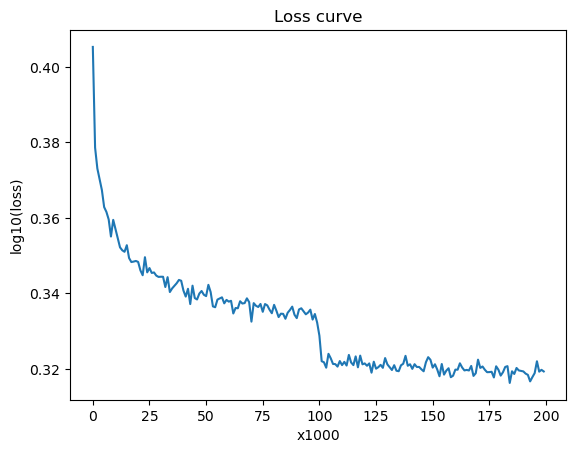

In [10]:
# plot the loss curve
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
plt.xlabel('x1000')
plt.ylabel('log10(loss)')
plt.title('Loss curve')
plt.show()

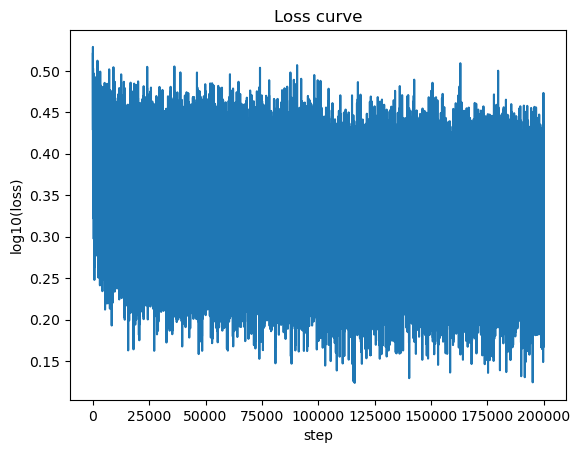

In [12]:
plt.plot(lossi)
plt.xlabel('step')
plt.ylabel('log10(loss)')
plt.title('Loss curve')
plt.show()

### Calibrating Final BatchNorm Statistics

In [13]:
with torch.no_grad():
  emb = C[Xtr]# pass the training set through
  embcat = emb.view(emb.shape[0], -1)# concatenate the vectors
  hpreact = embcat @ W1  # + b1
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

### Evaluating the Final Loss (Training vs. Validation)
Here we calculate the loss for a given data split (train or val).

- `@torch.no_grad()`: This decorator disables gradient tracking making the computation much faster and more memory-efficient which is appropriate since we are only evaluating, not training.

In [14]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  emb = C[x]  # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1  # + b1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)  # (N, n_hidden)
  logits = h @ W2 + b2  # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
  
split_loss('train')
split_loss('val')

train 2.0666232109069824
val 2.1051769256591797
